# Week 7: Autoencoders and Generative Adversarial Neural Networks (GANs)

Beyond neural networks for classification and regression, there is a world of interesting neural network research with very cool applications. In todays lecture we have talked about *latent spaces* and their importance in 
*generative models*. Generative models are, as the name suggests, models which define a procedure for *generating* data that look similar to the trianing data. They learn the underlying structure of the data, a (lower-dimensional) structure that can be explored to obtain new datapoints.

## Exercises

In [329]:
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, Input, BatchNormalization

### Autoencoders

The input of an autoencoder is typically some multi-dimensional tensor like an image and the output is a reconstruction of said tensor/image. The loss function typically used is squared error loss.

> **Ex. 7.1.2**: What is the "bottleneck" of an autoencoder? How can you use the autoencoder to encode and decode data once it has been trained?

The "bottleneck" of an autoencoder is the layer in the architecture with the least amount of neurons, where it's most condensed. The first half of the autoencoder encodes inputs by compressing the input it into fewer dimensions (a representation of the image in the latent space) while the second half of the autoencoder decodes the compressed input (interprests the latent space representation), restoring it as best as possible to its original form. 

In [330]:
diabetes = pd.read_csv('Diabetes2015/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

X = diabetes.drop('Diabetes_binary', axis=1)
Y = diabetes['Diabetes_binary']

X = X.values
Y = Y.values

In [331]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data
t = MinMaxScaler()
t.fit(x_train)
x_train = t.transform(x_train)
x_test = t.transform(x_test)

Having worked with Keras for a while now, the construction of an autoencoder is simple. Following this [tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder) we construct a subclass of the `keras.models.Model` class called `Autoencoder` that inherits the some methods we want for training (`.compile`, `.fit`) and inference (`.predict`)

In [332]:
n_inputs = 21

# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 3
e = Dense(round(float(n_inputs) / 2))(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = round(float(n_inputs) / 3)
bottleneck = Dense(n_bottleneck)(e)

In [333]:
# define decoder, level 1
d = Dense(round(float(n_inputs / 2)))(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 3
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [334]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

> **Ex. 7.1.3**: Run the code below to train the autoencoder on the mnist fashion data and visualize it attempting to encode the test data into a latent space and then decode it. How high do you have to go before you can make out the letter "Lee" on the jumper or the plaid/checkered pattern on the shirt?

In [335]:
# fit the autoencoder model to reconstruct input
history = model.fit(x_train, x_train, epochs=40, batch_size=32, verbose=2, validation_data=(x_test,x_test))

Epoch 1/40
1547/1547 - 2s - 2ms/step - loss: 0.0810 - val_loss: 0.0456
Epoch 2/40
1547/1547 - 1s - 678us/step - loss: 0.0486 - val_loss: 0.0385
Epoch 3/40
1547/1547 - 1s - 683us/step - loss: 0.0433 - val_loss: 0.0337
Epoch 4/40
1547/1547 - 1s - 679us/step - loss: 0.0400 - val_loss: 0.0318
Epoch 5/40
1547/1547 - 1s - 675us/step - loss: 0.0373 - val_loss: 0.0297
Epoch 6/40
1547/1547 - 1s - 709us/step - loss: 0.0354 - val_loss: 0.0273
Epoch 7/40
1547/1547 - 1s - 678us/step - loss: 0.0335 - val_loss: 0.0258
Epoch 8/40
1547/1547 - 1s - 686us/step - loss: 0.0314 - val_loss: 0.0239
Epoch 9/40
1547/1547 - 1s - 683us/step - loss: 0.0290 - val_loss: 0.0222
Epoch 10/40
1547/1547 - 1s - 759us/step - loss: 0.0266 - val_loss: 0.0204
Epoch 11/40
1547/1547 - 1s - 722us/step - loss: 0.0247 - val_loss: 0.0190
Epoch 12/40
1547/1547 - 1s - 741us/step - loss: 0.0233 - val_loss: 0.0182
Epoch 13/40
1547/1547 - 1s - 707us/step - loss: 0.0222 - val_loss: 0.0182
Epoch 14/40
1547/1547 - 1s - 683us/step - loss: 0

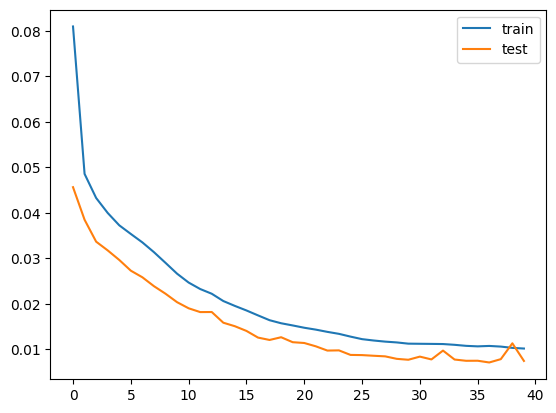

In [336]:
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [337]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

# # save the encoder to file
# encoder.save('encoder.keras')
# encoder = load_model('encoder.keras')

# encode the train data
x_train_encode = encoder.predict(x_train)

# encode the test data
x_test_encode = encoder.predict(x_test)

1547/1547 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


In [338]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# define AE_model
AE_model = LogisticRegression()

# fit AE_model on training set
AE_model.fit(x_train_encode, y_train)

# make prediction on test set
yhat = AE_model.predict(x_test_encode)

# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.7104866088268578


## NN

In [360]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras.layers import Activation


# creating neural net
nn_model = Sequential()
nn_model.add(Input(shape=(7,)))
nn_model.add(Dense(14, activation = 'relu'))
nn_model.add(Dense(5, activation = 'relu'))
nn_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.01, beta_1=0.9)

nn_model.compile(optimizer=optimizer,
              loss='BinaryCrossentropy',
              metrics=['accuracy'])


In [361]:
nn_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)               │ (None, 14)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 5)              │            75 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [362]:
# fit the model to the training data
nn_model.fit(x_train_encode, y_train, epochs=50, batch_size=16)

Epoch 1/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - accuracy: 0.6963 - loss: 0.5918
Epoch 2/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.7098 - loss: 0.5737
Epoch 3/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.7068 - loss: 0.5721
Epoch 4/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.7083 - loss: 0.5715
Epoch 5/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.7053 - loss: 0.5732
Epoch 6/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.7091 - loss: 0.5703
Epoch 7/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 300us/step - accuracy: 0.7117 - loss: 0.5652
Epoch 8/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step - accuracy: 0.7121 - loss: 0.5666
Epoch 9/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step - accuracy: 0.7089 - loss: 0.5688
Epoch 10/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - accuracy: 0.7109 - loss: 0.5670
Epoch 11/50
3093/3093 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.7105 - loss: 0.5656
Epoch 12

KeyboardInterrupt: 

In [ ]:
# evaluate the model on the test dataset
score = nn_model.evaluate(x_test_encode, y_test, batch_size=100)
print(score[0])
print(score[1])

## NN FE

In [307]:
# add new classifier layers

class1 = Dense(10, activation='relu')(encoder.layers[-1].output)
class2 = Dense(5, activation='relu')(class1)
output = Dense(1, activation='sigmoid')(class2)

nn_encoder = Model(inputs=encoder.inputs, outputs=output)

print(nn_encoder.summary())

Model: "functional_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 42)             │           924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_173         │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_173 (LeakyReLU)     │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_174         │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_174 (LeakyReLU)     │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 10)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_175         │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_175 (LeakyReLU)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 7)              │            77 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 10)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,557 (9.99 KB)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 2,416 (9.44 KB)

None


In [308]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


for layer in nn_encoder.layers[:-3]:
    layer.trainable = False

optimizer = Adam(learning_rate=0.001, beta_1=0.9)
# optimizer = "Adam"
nn_encoder.compile(optimizer=optimizer, loss="BinaryCrossentropy", metrics=['accuracy'])

nn_encoder.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6966 - loss: 0.5780 - val_accuracy: 0.7153 - val_loss: 0.5601
Epoch 2/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.7118 - loss: 0.5635 - val_accuracy: 0.7170 - val_loss: 0.5574
Epoch 3/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - accuracy: 0.7138 - loss: 0.5602 - val_accuracy: 0.7184 - val_loss: 0.5547
Epoch 4/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.7154 - loss: 0.5557 - val_accuracy: 0.7193 - val_loss: 0.5530
Epoch 5/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accuracy: 0.7124 - loss: 0.5576 - val_accuracy: 0.7194 - val_loss: 0.5519
Epoch 6/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.7177 - loss: 0.5544 - val_accuracy: 0.7187 - val_loss: 0.5520
Epoch 7/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accuracy: 0.7167 - loss: 0.5546 - val_accuracy: 0.7176 - val_loss: 0.5521
Epoch 8/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step - accuracy: 0.7151 -

In [309]:
y_pred = nn_encoder.predict(x_test)
nn_encoder.evaluate(x_test, y_test)

663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.7194 - loss: 0.5486


[0.5506343841552734, 0.7205299735069275]

Note, our definition of be abling to "make out" the phrase "Lee" was that we'd have to be able to recognize "Lee" without referencing the original image. Hence, we found that we had to go up to around 200 latent dimensions before we could get something that is legible enough to more clearly be "Lee". However, we found that the plaid/checkered pattern became more clearly recognizable around 100 latent dimensions.

> **Ex. 7.1.4**: Run the experiment using different values of `latent_dim` (e.g. `[2,16,64,128,512]`) and store the validation loss of the last iteration in the `history` variable for each. Then plot it, my plot looks [like this](https://dhsvendsen.github.io/images/latentdim_vs_reconerror.png).

In [ ]:
latent_dims = [2,16,64,128,512]
val_losses = []

for dim in latent_dims:
    print("\nExperiment " + str(len(val_losses) + 1) + ":")
    autoencoder_vl = Autoencoder(latent_dim = dim)
    autoencoder_vl.compile(optimizer='adam', loss=losses.MeanSquaredError())
    history_vl = autoencoder_vl.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))
    val_losses.append(history_vl.history['val_loss'][-1])

In [ ]:
plt.plot(latent_dim, val_losses, marker='o')
plt.title('Validation Loss vs. Latent Dimension')
plt.xlabel('Latent Dimension')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

> **Ex. 7.1.5**: Set the `latent_dim = 2` and describe what happens to the test data - what do you think happens to the sandal? Then plot the representation of the test data in the latent space, colouring each point according to its class and describe what you see. [Example plot](https://dhsvendsen.github.io/images/two_latent_dims_simple.png).

In [ ]:
plt.scatter(encoded_imgs[:,0],encoded_imgs[:,1],color=["C"+str(i) for i in y_test])

When latent_dim = 2, the sandal reconstruction becomes indifferenitable from the sneaker reconstruction. Their reconstructions are nearly identical. The plaid shirt also begins to resemble an outline of a pair of sneaker and pants.

We believe this is because, when we limit our dimensions to only 2 dimensions, the autoencoder must extract general traits that are broadly shared among the clothing categories. For example, it extracts a general feature shared by different types of footwear and another feature shared by pants and jackets. There could also be some class bias where, for example, there are more sneakers than flip-flops so that a flip-flop is more likely to be reconstructed as a sneaker. 

> **Ex. 7.1.6**: It appears that the encoding and decoding scheme is not very effective! Add an extra `Dense` layer of `128` neurons (or more) with `activation='relu'` to both the encoder and the decoder; plot the reconstructions of the test images again. We are cramming all the information of 784 pixels into a 2-dimensional vector space - lets see if there is a way to do it which retains key information. Plot the 2-D latent representation of the test data again. Using this ([Example](https://dhsvendsen.github.io/images/two_latent_dims_ordered.png)) plot, explain why our reconstruction error is lower.

In [ ]:
class Autoencoder128(Model):
    def __init__(self, latent_dim):
        super(Autoencoder128, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
autoencoder128 = Autoencoder128(latent_dim = 2)
autoencoder128.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder128.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
# Visualization cell
encoded_imgs = autoencoder128.encoder(x_test).numpy()
decoded_imgs = autoencoder128.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
plt.scatter(encoded_imgs[:,0],encoded_imgs[:,1],color=["C"+str(i) for i in y_test])

Our reconstruction error is lower because it enhances both encoding and decoding.

`Encoding` improves because the added layer is another feature extractor that is able to extract higher-level features before compression. These provide more information (e.g. flip-flop straps, sole shape, etc.) that can be better condensed into more informative macro features. Moreover, features that are shared between separate classes are viewed in greater context as higher-level features so that the model can more easily condense them in a manner where these shared features are more distinguishable by classes. For example, pants and jackets both have sleeves, but adding another layer can give more information about the positioning of sleeves that differentiate jackets and pants. This can then be compressed into a latent space with more informative dimensions.  

`Decoding`improves because there is another layer with more neurons that can extract some lower-level features from the compression before being passed onto a larger Dense layer that can go further and parcel out higher-level features. 